### Understanding Interaction Terms in Regression: A Practical Example
#### Overview
In regression modeling, interaction terms are used to capture the combined effect of two or more variables on the target variable. This can be particularly useful in scenarios where the relationship between the variables and the target variable is not simply additive. In this example, we explore the concept of interaction terms using a practical example: predicting the time spent by users on an ecommerce platform based on their activity.



In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

##### Example: User Activity and Time Spent
Let's first generated a synthetic dataset to simulate user activity on an ecommerce platform. The dataset includes:

- added_in_cart: Whether the user added items to cart (1 for adding to cart 0r 0 for not adding to cart).
- purchased: Whether the user made a purchase or now (1 for making a purchase or 0 for not making a purchase).
- time_spent: The total time the user spent on the website (continuous). We are trying to predict this, i.e, how long a user will spend on the ecommerce platform based on whether they add items to cart and making a purchase.

In [23]:
# Function to generate synthetic data
def generate_synthetic_data(n_samples=2000):
    np.random.seed(42)
    added_in_cart = np.random.randint(0, 2, n_samples)
    purchased = np.random.randint(0, 2, n_samples)
    time_spent = 3 + 2*purchased + 2.5*added_in_cart + 4*purchased*added_in_cart + np.random.normal(0, 1, n_samples)
    return pd.DataFrame({'purchased': purchased, 'added_in_cart': added_in_cart, 'time_spent': time_spent})

# Generate synthetic data
df = generate_synthetic_data()
df.head()

,purchased,added_in_cart,time_spent
0,0,0,2.122017
1,1,1,10.673120
2,1,0,4.773521
3,1,0,5.367366
4,1,0,5.913585


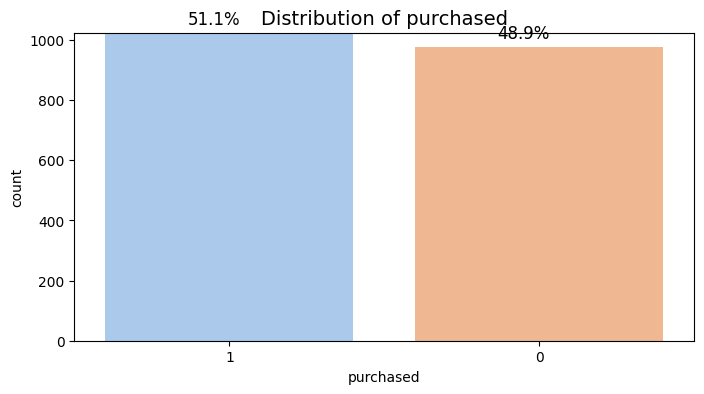

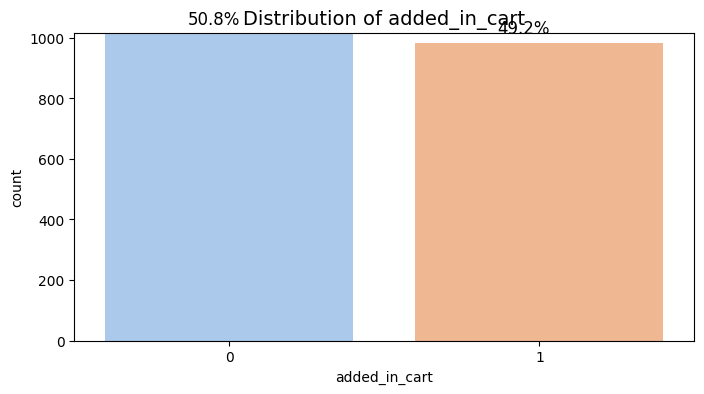

In [24]:
def plot_categorical_distributions(data, columns, top_n=10):
    """
    Plots the distributions of specified categorical columns.
    """
    for column in columns:
        top_categories = data[column].value_counts().nlargest(top_n).index
        top_data = data[data[column].isin(top_categories)]
        
        plt.figure(figsize=(8, 4))
        plt.title(f"Distribution of {column}", fontsize=14)
        plot = sns.countplot(x=column, data=top_data, palette='pastel', order=top_categories)
        plt.ylim(0, top_data[column].value_counts().max() + 1)
        
        total = len(top_data[column])
        for p in plot.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height() / total)
            x = p.get_x() + p.get_width() / 2 - 0.05
            y = p.get_y() + p.get_height()
            plot.annotate(percentage, (x, y), size=12, ha='center', va='center', xytext=(0, 10), textcoords='offset points')
        
        plt.xticks(rotation=0)
        plt.show()

cat_vars = ['purchased', 'added_in_cart']
plot_categorical_distributions(df, cat_vars)

- By looking at the distribution of purchased and added_in_cart we can say that most users add items to cart but not make a purchase.
- The balanced distributions of purchased and added_in_cart highlight their potential as significant predictors time spent on the platform.

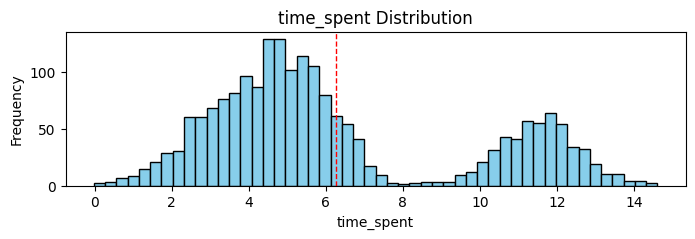

In [25]:
def plot_numerical_distributions(df, columns):
    """
    Plots the distributions of specified numerical columns in a DataFrame.
    
    """
    for column in columns:
        if column in df.columns:
            plt.figure(figsize=(8, 2))
            plt.hist(df[column].dropna(), bins=50, color='skyblue', edgecolor='black')
            plt.title(f'{column} Distribution')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.axvline(df[column].mean(), color='red', linestyle='dashed', linewidth=1)
            plt.show()
        else:
            print(f"Column '{column}' not found in DataFrame")

columns_to_plot = ['time_spent']
plot_numerical_distributions(df, columns_to_plot)

- Bimodal Distribution of Time Spent: The time spent by users shows two distinct peaks, indicating different patterns of engagement.

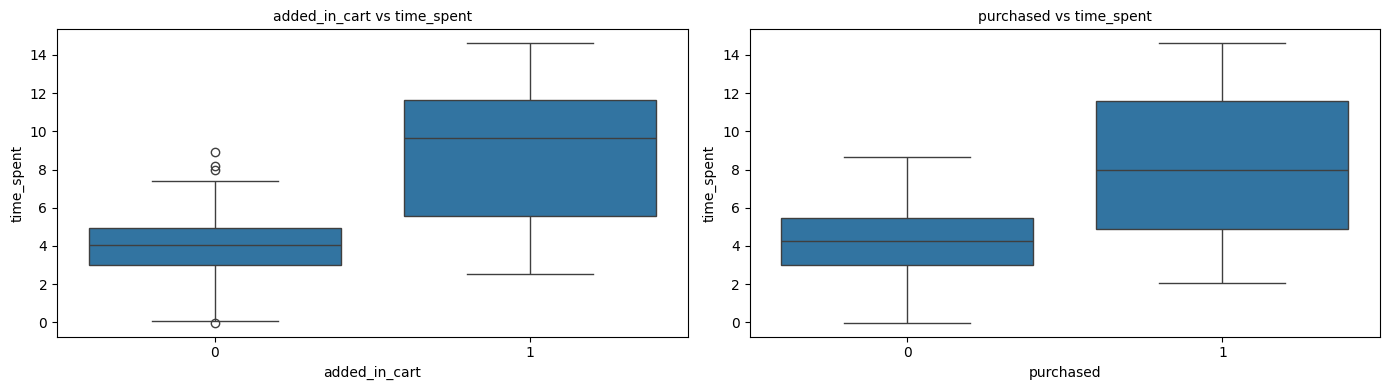

In [26]:
categorical_cols = ['added_in_cart', 'purchased']

num_plots = len(categorical_cols)
n_cols = 2
n_rows = (num_plots + 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, n_rows * 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
axes = axes.flatten()

# Plot each categorical column against 'Sale Price'
for i, col in enumerate(categorical_cols):
    sns.boxplot(data=df, x=col, y='time_spent', ax=axes[i])
    axes[i].set_title(f'{col} vs time_spent', fontsize=10)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('time_spent')

# Remove any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- As indicated by the boxplots above, both adding items to the cart and making a purchase are associated with significantly higher time spent on the platform. The median time spent by users who engaged in these actions is roughly double that of users who did not engage in these actions.

### Modelling

Since we are exploring the use of interaction terms, we'll start by building a regression model to predict the time users spend on the website based on two actions: adding an item to the cart and making a purchase. Initially, we will build the model without considering the interaction between these actions. This means we want to see if each action independently affects the time spent on the website.

Next, we will build another model that includes the interaction term between adding items to the cart and making a purchase. This will allow us to compare the combined effect of these actions on the time spent on the website with their individual effects. This means we want to determine if users who both add items to their cart and make a purchase spend more time on the website than what would be expected by simply adding together the effects of each action done independently.

In [60]:
# Model without interaction term
X = df[['purchased', 'added_in_cart']]
y = df['time_spent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Add a constant for the intercept
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_const).fit()
y_pred = model.predict(X_test_const)

# Calculate metrics for model without interaction term
train_r2 = model.rsquared
test_r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Model without Interaction Term:")
print('Training R-squared Score (%):', round(train_r2 * 100, 4))
print('Test R-squared Score (%):', round(test_r2 * 100, 4))
print("MSE:", round(mse, 4))
print(model.summary())

Model without Interaction Term:
Training R-squared Score (%): 82.3353
Test R-squared Score (%): 80.3671
MSE: 2.1189
                            OLS Regression Results                            
Dep. Variable:             time_spent   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     3256.
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        15:38:45   Log-Likelihood:                -2485.7
No. Observations:                1400   AIC:                             4977.
Df Residuals:                    1397   BIC:                             4993.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------

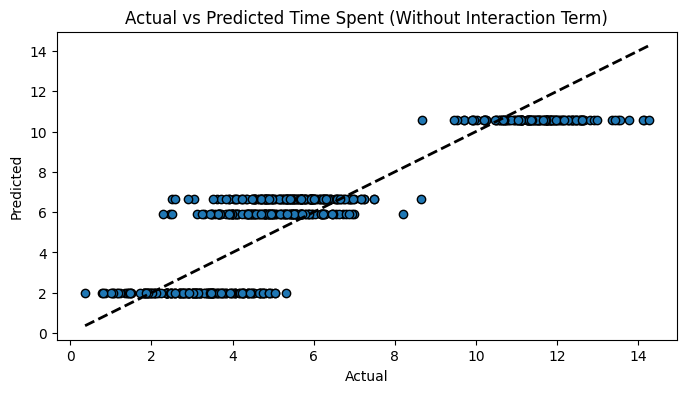

In [61]:
# Function to plot actual vs predicted
def plot_actual_vs_predicted(y_test, y_pred, title):
    plt.figure(figsize=(8, 4))
    plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.show()

# Plot without interaction term
plot_actual_vs_predicted(y_test, y_pred, 'Actual vs Predicted Time Spent (Without Interaction Term)')

- The model without the interaction term explains about 85% (R-squared) of the variance in the time_spent, with a mean squared error (MSE) of 2.11. This means that, on average, the predictions of time_spent are off by about 2.11 squared units. While this model is fairly accurate, there's room for improvement.
- This plot visually confirms that while the model performs reasonably well, there is significant room for improvement, particularly in capturing higher values of time_spent.

In [62]:
# Add interaction term
df['purchased_added_in_cart'] = df['purchased'] * df['added_in_cart']
X = df[['purchased', 'added_in_cart', 'purchased_added_in_cart']]
y = df['time_spent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Add a constant for the intercept
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

model_with_interaction = sm.OLS(y_train, X_train_const).fit()
y_pred_with_interaction = model_with_interaction.predict(X_test_const)

# Calculate metrics for model with interaction term
train_r2_with_interaction = model_with_interaction.rsquared
test_r2_with_interaction = r2_score(y_test, y_pred_with_interaction)
mse_with_interaction = mean_squared_error(y_test, y_pred_with_interaction)

print("\nModel with Interaction Term:")
print('Training R-squared Score (%):', round(train_r2_with_interaction * 100, 4))
print('Test R-squared Score (%):', round(test_r2_with_interaction * 100, 4))
print("MSE:", round(mse_with_interaction, 4))
print(model_with_interaction.summary())


Model with Interaction Term:
Training R-squared Score (%): 91.4592
Test R-squared Score (%): 90.4608
MSE: 1.0295
                            OLS Regression Results                            
Dep. Variable:             time_spent   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     4983.
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        15:39:14   Log-Likelihood:                -1977.0
No. Observations:                1400   AIC:                             3962.
Df Residuals:                    1396   BIC:                             3983.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----

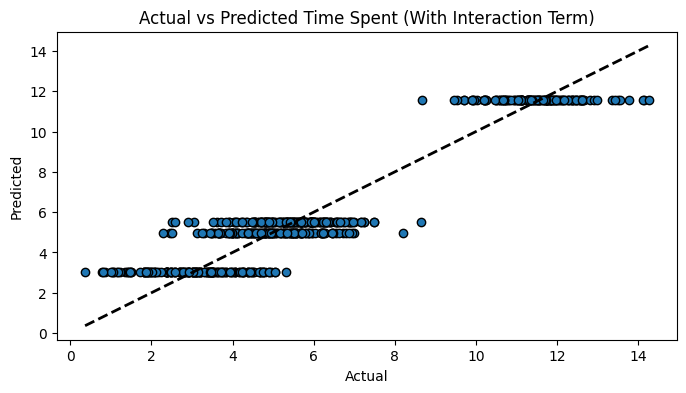


Comparison of Models:
R-squared without Interaction Term: 80.3671
R-squared with Interaction Term: 90.4608
MSE without Interaction Term: 2.1189
MSE with Interaction Term: 1.0295


In [63]:
# Plot with interaction term
plot_actual_vs_predicted(y_test, y_pred_with_interaction, 'Actual vs Predicted Time Spent (With Interaction Term)')

# Print comparison
print("\nComparison of Models:")
print("R-squared without Interaction Term:", round(r2_score(y_test, y_pred)*100,4))
print("R-squared with Interaction Term:", round(r2_score(y_test, y_pred_with_interaction)*100,4))
print("MSE without Interaction Term:", round(mean_squared_error(y_test, y_pred),4))
print("MSE with Interaction Term:", round(mean_squared_error(y_test, y_pred_with_interaction),4))

- The scatter plot with the interaction term shows predicted values much closer to the actual values, indicating a better fit.
- The higher R-squared value (from 80.36% to 90.46%) indicates that the model with the interaction term explains much more of the variance in the time_spent.
- The lower MSE (from 2.11 to 1.02) indicates that the predictions of the model with the interaction term are more accurate.
- This improved fit is evident from the closer alignment of points to the diagonal line, especially for higher values of time_spent. The interaction term helps capture the combined effect of user actions on the time spent.

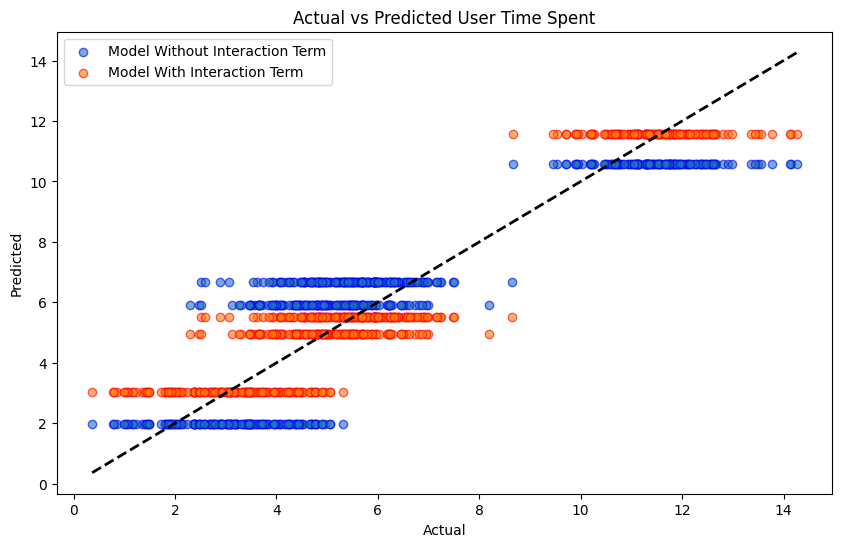

In [65]:
def plot_actual_vs_predicted_combined(y_test, y_pred1, y_pred2, title1, title2):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred1, edgecolors='blue', label=title1, alpha=0.6)
    plt.scatter(y_test, y_pred2, edgecolors='red', label=title2, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted User Time Spent')
    plt.legend()
    plt.show()

plot_actual_vs_predicted_combined(y_test, y_pred, y_pred_with_interaction, 'Model Without Interaction Term', 'Model With Interaction Term')

- The blue points represent the model predictions without the interaction term. These points are more spread out from the diagonal line, especially for higher actual time spent values, indicating less accurate predictions.
- The red points represent the model predictions with the interaction term. These points are closer to the diagonal line, showing that the model with the interaction term makes more accurate predictions, particularly for higher actual time spent values.

#### Conclusion:
The improvement in the model's performance with the interaction term demonstrates that sometimes adding an interaction terms to your model may enhance its importance. This example highlights how interaction terms can capture additional information that is not apparent from the main effects alone. In practice, considering interaction terms in regression models can lead to more accurate and insightful predictions.